# Лабораторная работа №6. Построение пайплайна одномерной регрессии
## Шкуратова Д.В. МКТ

In [206]:
import numpy as np
import seaborn as sns
import pandas as pd


In [207]:
df = pd.read_csv('Advertising.csv')
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


## 1. Описание данных
$$ \left. \begin{array}  \text{TV} \\ Radio \\ Newspaper \end{array} \right\} - \text{тыс. \$  потраченные на рекламу на ТВ, радио и в газетах} $$
$$Sales - \text{тыс. ед. проданного товара}$$

In [208]:
df = df.drop(df.columns[0], axis=1)
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Построим модель для предсказания количества продаж в зависимости от суммы вложенной в рекламу

##  2. Визуализация

D:\Python\VirtualVenv\MathVenv\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


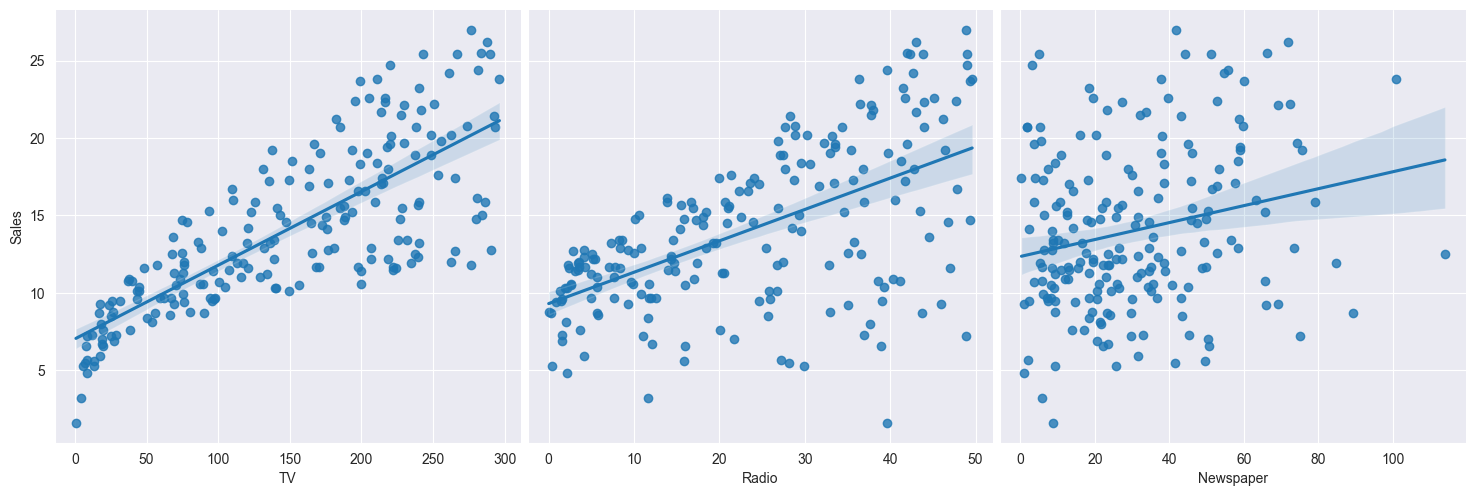

In [209]:
sns.pairplot(data=df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', kind='reg', size=5)

По графикам нельзя сказать, что взаимосвязь каждого отдельного признака с зависимой переменной линейная, но лучше всего для построения подойдет взаимосвязь TV ~ Sales, хуже всего - Newspaper ~ Sales

In [210]:
# Проверка на пропуски
df.isna().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

## Разделение на матрицу признаков и зависимую переменную

In [211]:
from IPython.core.display import Math

x = df.iloc[:, 0:1].values
y = df.iloc[:, -1].values
# Получаем таблично заданную функцию
display(Math(r'y_i = \beta_0 + \beta_1 x_i'))
x[:5], y[:5]

<IPython.core.display.Math object>

(array([[230.1],
        [ 44.5],
        [ 17.2],
        [151.5],
        [180.8]]),
 array([22.1, 10.4,  9.3, 18.5, 12.9]))

## Модель линейной регрессии
Определим функцию, которая будет строить модель с помощью библиотеки и вычислять среднеквадратическую оценку и коэффициент детерминации для того, чтобы оценить точность модели для разного объема тестовой выборки

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
def build_linear_regression(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        x_data,
        y_data,
        test_size=test_size,
        random_state=0
    )
    # Обучение модели регрессии
    regressor = LinearRegression()
    regressor.fit(x_train, y_train)
    # Вычисление MSE
    beta0, beta1 = regressor.intercept_, regressor.coef_
    y_pred = regressor.predict(x_test)
    sum_sd = sum((y_train[i] - beta0 - beta1 * x_train[i][0]) ** 2 \
                 for i in range(x_train.size))
    mse = sum_sd / x_train.size
    rmse = mse ** (1/2)
    # Вычисление R^2
    mean_y = np.mean(y_train)
    sum_mean_sd  = sum((mean_y - y_train[i])**2 for i in range(y_train.size))
    R2 = 1 - sum_sd/sum_mean_sd
    d = {
        'x_train': x_train,
        'y_train': y_train,
        'x_test': x_test,
        'y_test': y_test,
        'mse': mse,
        'rmse': rmse, 
        'R': R2,
        'regressor':regressor
    }
    return d
 
   

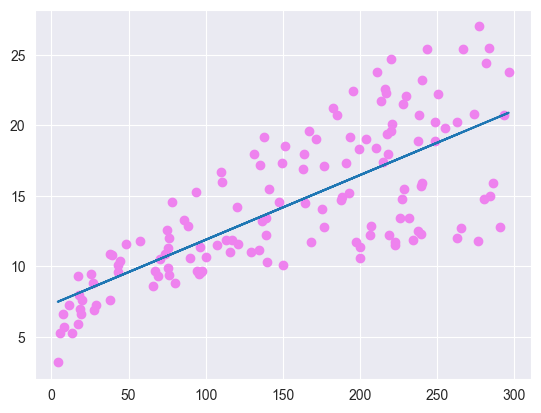

In [213]:
import matplotlib.pyplot as plt

d3 = build_linear_regression(x_data=x, y_data=y, test_size=0.3)
plt.scatter(d3['x_train'], d3['y_train'], color='violet')
plt.plot(d3['x_train'], d3['regressor'].predict(d3['x_train']))


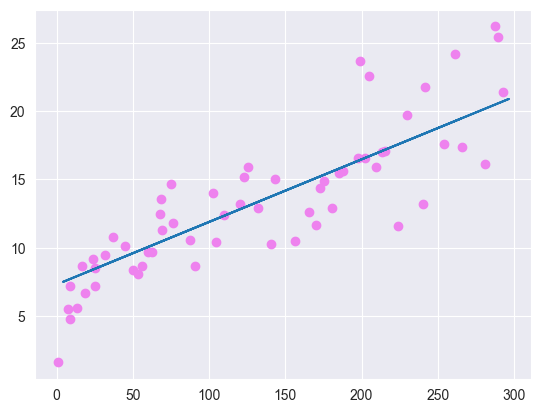

In [214]:
plt.scatter(d3['x_test'], d3['y_test'], color='violet')
plt.plot(d3['x_train'], d3['regressor'].predict(d3['x_train']))

В выборке есть выбросы, что может плохо сказаться на итоговом результате

Видим, что зависимость между переменными есть, но она не линейная

## MSE
Среднеквадратичная ошибка, используется для оценки моделей, выбирается модель с наименьшим MSE

In [215]:
d3['mse'], d3['rmse']

(array([11.83683932]), array([3.4404708]))

## $R^2$ - коэффициент детерминации
$$R^2 = 1 - \frac{\sum_1^n (y_i - \hat{y_i})^2}{\sum_1^n(\overline{y} - y_i)^2}$$
$$R^2 \in (-\infty, 1]$$
Чем ближе к 1, тем больше модель соответствует данным

In [216]:
d3['R']

array([0.55523361])

Проверим как изменятся MSE и $R^2$, если уменьшить объем тестовой выборки на 10%

In [217]:
d2 = build_linear_regression(x, y, 0.2)

In [218]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['test_size', '0.3', '0.2']
table.add_row(['beta0', d3['regressor'].intercept_, d2['regressor'].intercept_])
table.add_row(['beta1', d3['regressor'].coef_, d2['regressor'].coef_])
table.add_row(['mse', d3['mse'], d2['mse']])
table.add_row(['rmse', d3['rmse'], d2['rmse']])
table.add_row(['R^2', d3['R'], d2['R']])
table

test_size,0.3,0.2
beta0,7.310810165411681,7.292493773559356
beta1,[0.04581434],[0.04600779]
mse,[11.83683932],[10.61723842]
rmse,[3.4404708],[3.25841041]
R^2,[0.55523361],[0.58847425]


Модель с объемом обучающейся выборки = 0.8 лучше описывает данные: 
$$MSE_20 < MSE_30 \ \ R^2_{20} > R^2_{30}$$
Это может быть связано с тем, что выборка небольшая (200 строк), большая часть данных содержится в обучающейся выборке, поэтому MSE меньше для test_size=0.2

Незначительное отличие коэффициентов детерминации можно объяснить распределением данных, которое мы видели на графике:
$R^2$ будет меняться в зависимости от того, какие данные попали в обучающую выборку 

Для обоих разделений коэффициент детерминации небольшой, почти половина данных не описывается моделью, для улучшения результатов можно взять логарифм по переменной TV или прологарифмировать  зависимую и независимую переменные.